In [1]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM, GlobalAveragePooling1D, MultiHeadAttention
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tensorflow as tf
import shap

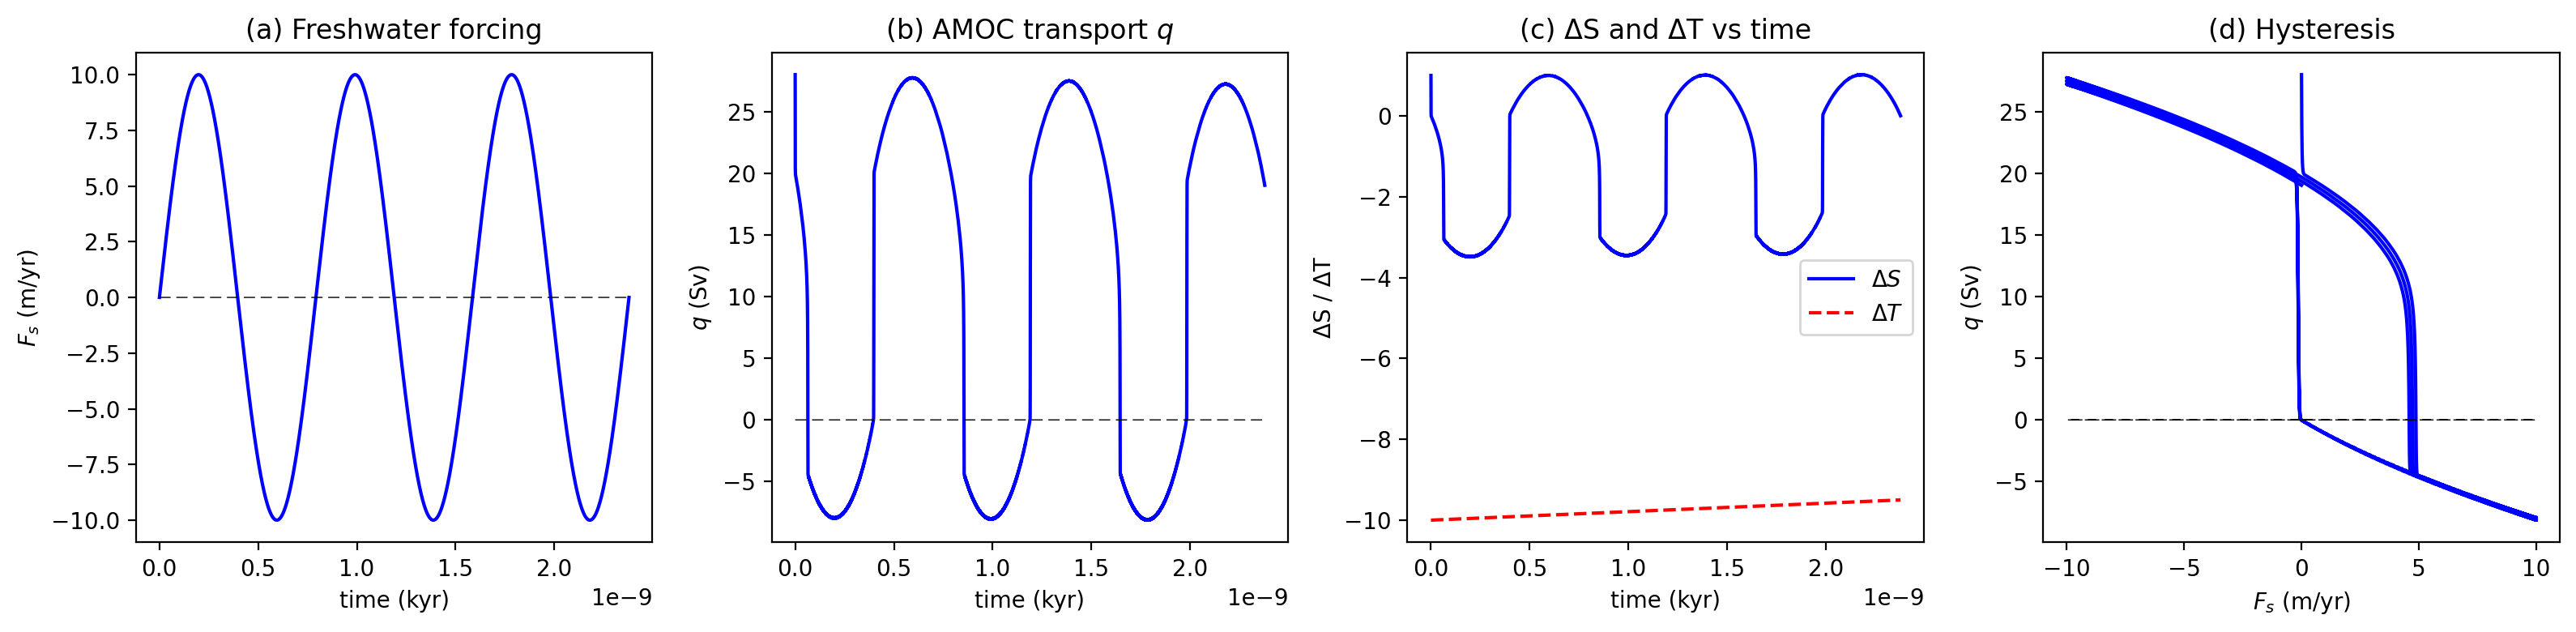

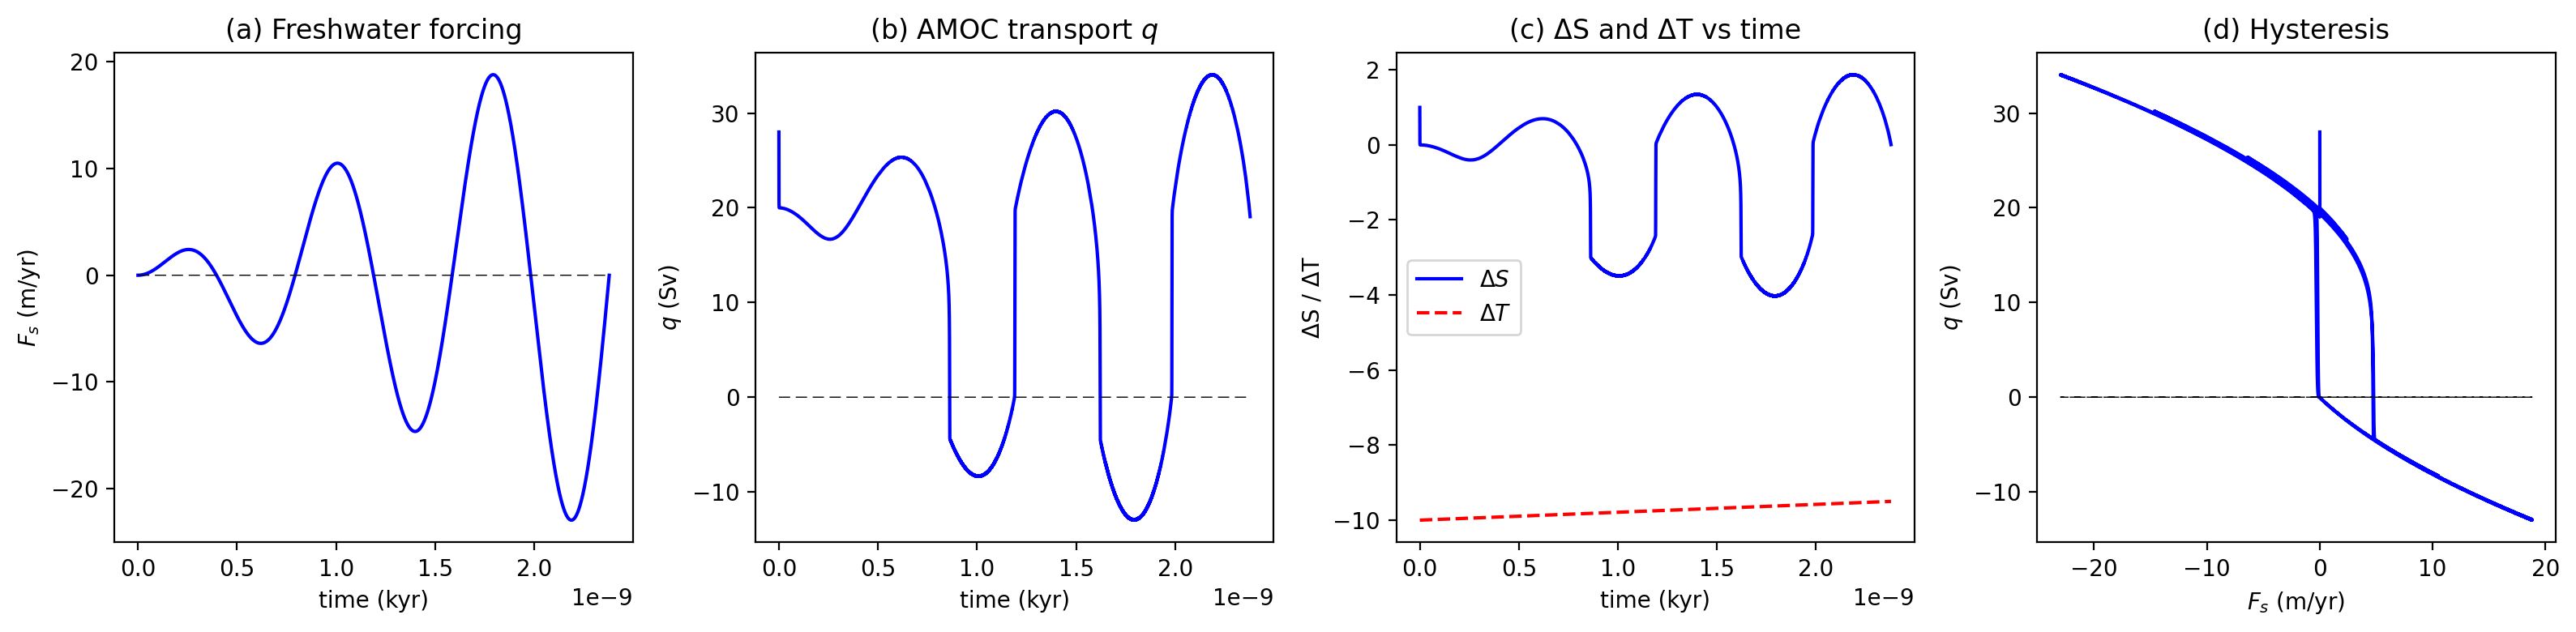

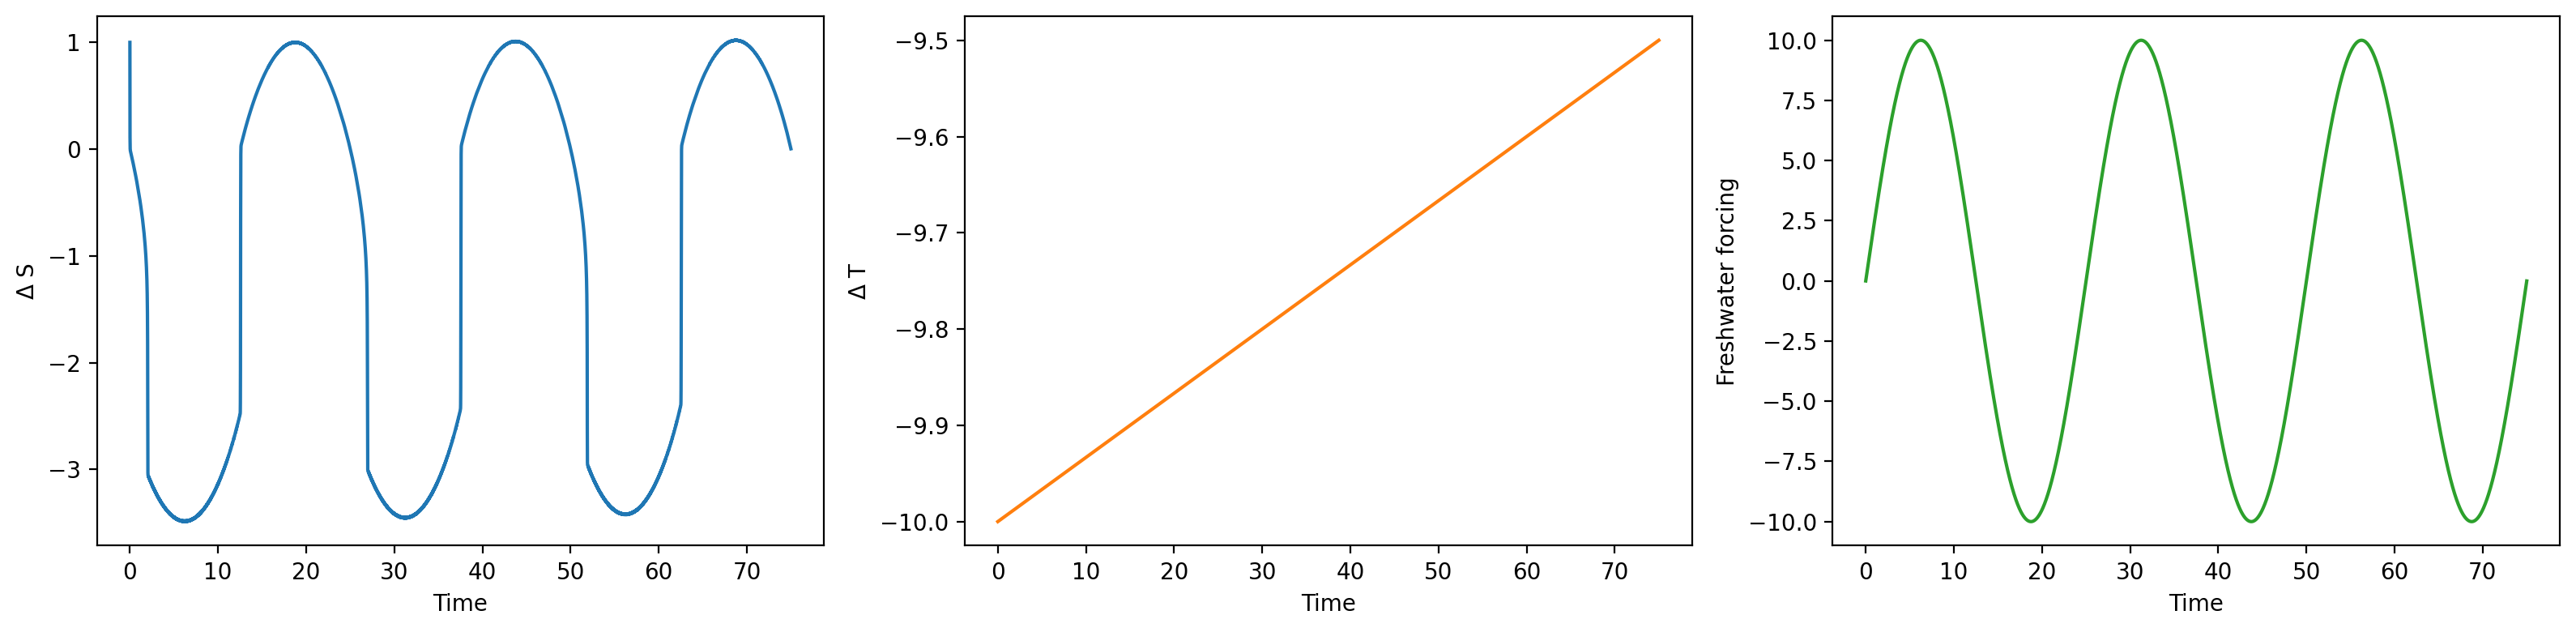

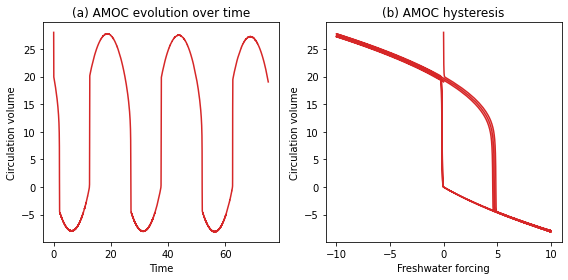

In [2]:
%run 00_generate_data.ipynb

**Layer-wise relevance propagation plotting functions**

In [9]:
str.upper("mlp")

'MLP'

In [17]:
def plot_lrp_time_fwf(forcing_type, model_type):
    
    """
    Generate a figure with two subplots of layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).

    Returns
    -------
    None
        Displays a figure with:
        - y-axis: layer-wise relevance values
        - x-axis: time and freshwater forcing
    """

    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
    lrp_sal_mean = lrp_avg[:, 1]
    lrp_temp_mean = lrp_avg[:, 2]
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    
    fig.suptitle('Layer-wise Relevance Propagation for ' + str.upper(model_type) + ' ensemble')
    
    ax[0].plot(input_data[:end, 0], lrp_sal_mean)
    ax[0].plot(input_data[:end, 0], lrp_temp_mean)
    ax[1].plot(input_data[:end, 3]/Fs_to_m_per_year, lrp_sal_mean)
    ax[1].plot(input_data[:end, 3]/Fs_to_m_per_year, lrp_temp_mean)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Relevance')
    ax[1].set_xlabel('Freshwater Forcing')
    ax[1].set_ylabel('Relevance')
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
               loc='lower right')
    plt.close()
    
    return fig

In [11]:
def plot_lrp_dominance_members(forcing_type, model_type, xaxis):
    """
    Generate a figure with 12 subplots of dominating layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).

    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing 
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp = lrp.mean(axis=2)
    fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
    if xaxis == "t":
        fig.supxlabel('Time')
    else:
        fig.supxlabel('Freshwater Forcing')
    fig.supylabel('AMOC')
    fig.suptitle('Comparing Relevance Values for ' + str.upper(model_type) + ' Ensemble Members')
    ax = ax.flatten()
    for i in range(12):
        lrp_i = lrp[i, :, :]
        lrp_temp = lrp_i[:, 2]
        lrp_sal = lrp_i[:, 1]
        colors = np.where(lrp_temp > lrp_sal, '#ff7f0e', '#1f77b4')
        if xaxis == "t":
            scatter = ax[i].scatter(input_data[:end, 0], qplot[:end]/Sv, 
                                c=colors, marker='o', s=18, alpha=0.5)
            ax[i].plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
        else: 
            scatter = ax[i].scatter(input_data[:end, 3]/Fs_to_m_per_year, qplot[:end]/Sv, 
                                c=colors, marker='o', s=18, alpha=0.5)
            ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
        
        ax[i].axhline(0, color='black', linestyle='--')

    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
               loc='lower right')

In [30]:
def plot_lrp_dominance_ensemble(forcing_type, model_type, xaxis):
    """
    Generate a figure with dominating averaged (over the ensemble members) layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).
        
    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
    lrp_sal_mean = lrp_avg[:, 1]
    lrp_temp_mean = lrp_avg[:, 2]
    
    fig, ax = plt.subplots()

    colors = np.where(lrp_temp_mean > lrp_sal_mean, '#ff7f0e', '#1f77b4')
    if xaxis == "t":
            scatter = ax.scatter(input_data[:end, 0], qplot[:end]/Sv, 
                        c=colors, marker='o', s=18)
    else: 
            scatter = ax.scatter(input_data[:end, 3]/Fs_to_m_per_year, qplot[:end]/Sv, 
                        c=colors, marker='o', s=18)

    if xaxis == "t":
        ax.set_xlabel('Time')
        ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
    else:
        ax.set_xlabel('Freshwater Forcing')
        ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
        
    ax.set_ylabel('AMOC')
    ax.set_title('Mean Relevance Values for ' + str.upper(model_type) + ' Ensemble')
    
    ax.axhline(0, color='black', linestyle='--')

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='#ff7f0e', markersize=10),
                     plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='#1f77b4', markersize=10)]
    ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
              loc='lower right')
    plt.close()
    return fig

In [78]:
def plot_lrp_time_gradient(forcing_type, model_type):
    """
    Generate a figure showing AMOC evolution and feature relevance over time.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).

    Returns
    -------
    None
        Displays a 2-panel figure:
        - Top: AMOC strength vs. time
        - Bottom: Layer-wise relevance (ΔSalinity, ΔTemperature) vs. time
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
    lrp_matrix = lrp_avg[:, 1:3].T  
    time = input_data[:, 0]
    feature_names = ['$\Delta$ Salinity', '$\Delta$ Temperature']
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    ax[0].plot(time, qplot/Sv, color='black')
    ax[0].set_ylabel('AMOC')

    # Sort data by timea
    sorted_idx = np.argsort(time[:end])
    lrp_sorted = lrp_matrix[:, sorted_idx]
    im = ax[1].imshow(
        lrp_sorted,
        aspect='auto',
        cmap='coolwarm',
        origin='lower',
        interpolation='none',
        vmin=-1.5,
        vmax=0.5
        #extent=[input_data[:,0].min(), input_data[:,0].max(), 0, len(feature_names)]
    )


    # Y-axis: feature labels
    ax[1].set_yticks(np.arange(len(feature_names)) + 0.5)
    ax[1].set_yticklabels(feature_names)
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Features")

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Relevance")
    
    fig.suptitle('Time Evolution of Relevance for ' + str.upper(model_type) + ' Ensemble')
    
    plt.close()
    return fig

In [79]:
def plot_lrp_fwf_gradient(forcing_type, model_type):
    """
    Generate a figure showing AMOC evolution and feature relevance over freshwater forcing.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).

    Returns
    -------
    None
        Displays a 2-panel figure:
        - Top: AMOC strength vs. freshwater forcing
        - Bottom: Layer-wise relevance (ΔSalinity, ΔTemperature) vs. time
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_{model_type}_{forcing_type}.npy')
    end = len(input_data)
    if model_type == "lstm":
        if forcing_type == "s":
            end = 100000 - 16 + 1 
        else:
            end = 100000 - 32 + 1
        lrp_avg = lrp.mean(axis=(0, 2))
    else:
        lrp_avg = lrp.mean(axis=0)
    lrp_matrix = lrp_avg[:, 1:3].T  
    fwf = input_data[:, 3]
    feature_names = ['$\Delta$ Salinity', '$\Delta$ Temperature']
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    ax[0].plot(fwf/Fs_to_m_per_year, qplot/Sv, color='black')
    ax[0].set_ylabel('AMOC')

    # Sort data by timea
    sorted_idx = np.argsort(fwf[:end])
    lrp_sorted = lrp_matrix[:, sorted_idx]
    im = ax[1].imshow(
        lrp_sorted,
        aspect='auto',
        cmap='coolwarm',
        origin='lower',
        interpolation='none'
        #extent=[input_data[:,3].min(), input_data[:,3].max(), 0, len(feature_names)]
    )


    # Y-axis: feature labels
    ax[1].set_yticks(np.arange(len(feature_names)) + 0.5)
    ax[1].set_yticklabels(feature_names)
    ax[1].set_xlabel("Freshwater Forcing")
    ax[1].set_ylabel("Features")

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Relevance")
    
    fig.suptitle('Evolution of Relevance for ' + str.upper(model_type) + ' Ensemble with respect to Freshwater Forcing')
    
    
    plt.close()
    return fig

In [80]:
fig = plot_lrp_time_gradient("ns", "lstm")

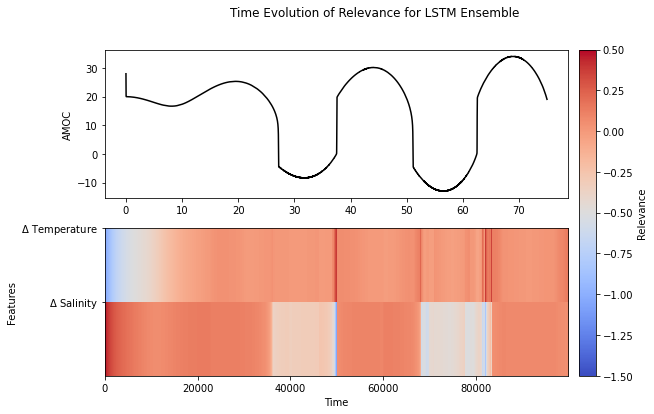

In [81]:
fig

In [72]:
fig.savefig('/Users/sanahsuri/Downloads/amoc_xai_draft_v2/figures/lrp/lrp_time_grad_lstm_ns.pdf')

In [258]:
lrp = np.load(f'lrp_npy/lrp_lstm_s.npy')

In [261]:
lrp.mean(axis=0).shape

(99985, 16, 4)

In [269]:
def plot_lrp_lstm_steps(forcing_type):
    """
    Generate a figure with dominating averaged (over the ensemble members) layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).
        
    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing
    """
    input_data, output_data, qplot = get_data(forcing_type)
    lrp = np.load(f'lrp_npy/lrp_lstm_{forcing_type}.npy')
    end = len(input_data)
    if forcing_type == "s":
        end = 100000 - 16 + 1 
        fig, ax = plt.subplots(4, 4, figsize=(20, 15))
    else:
        end = 100000 - 32 + 1
        fig, ax = plt.subplots(8, 4, figsize=(20, 15))
        
    lrp_avg = lrp.mean(axis=0)
    lrp_sal_mean = lrp_avg[:, :, 1]
    lrp_temp_mean = lrp_avg[:, :, 2]
    ax = ax.flatten()
    
    for i in range(len(ax)):
        ax[i].plot(lrp_sal_mean[:, i], label='salinity lrp');
        ax[i].plot(lrp_temp_mean[:, i], label='temp lrp');
        
    fig.supylabel('Relevance')
    fig.supxlabel('Time step')
    fig.suptitle('Time Step Relevance Values for LSTM Ensemble')
    

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='#ff7f0e', markersize=10),
                     plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor='#1f77b4', markersize=10)]
    ax[-1].legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
              loc='lower right')
    

**SHAP plotting functions**

In [18]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

In [19]:
def data_for_shap_ts(forcing_type, model_type):
    
    if forcing_type == "s":
        time_steps = 16
    else:
        if model_type == "lstm":
            time_steps = 32
        else:
            time_steps = 64
            
    # getting data
    input_data, output_data, qplot = get_data(forcing_type)
    X_train = input_data[0:60032]
    y_train = output_data[0:60032]
    X_val = input_data[61024:81000]
    y_val = output_data[61024:81000]
    X_test = input_data[81992:100000]
    y_test = output_data[81992:100000]
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    input_scaled = scaler.transform(input_data)

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
    X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
    input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)
    
    num_sequences = input_seq.shape[0]
    
    # data for SHAP
    background_data = shap.kmeans(X_train_seq.reshape(X_train_seq.shape[0], -1), 10)
    
    # for reproducibility
    rng = np.random.default_rng(seed=42)
    qplot_smooth = qplot / Sv
    seq_grad = np.array([
    np.mean(np.abs(np.gradient(qplot_smooth[i:i+time_steps])))
    for i in range(num_sequences)
    ])
    seq_probs = seq_grad / seq_grad.sum()
    sample_size = 1000
    sample_start_indices = rng.choice(num_sequences, size=1000, replace=False, p=seq_probs)

    input_sample = input_seq[sample_start_indices]
    
    return background_data, input_sample, sample_start_indices

In [20]:
def data_for_shap(forcing_type, model_type):
    
    # getting data
    input_data, output_data, qplot = get_data(forcing_type)
    X_train = input_data[0:60032]
    y_train = output_data[0:60032]
    X_val = input_data[61024:81000]
    y_val = output_data[61024:81000]
    X_test = input_data[81992:100000]
    y_test = output_data[81992:100000]
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    input_scaled = scaler.transform(input_data)
    
    # data for SHAP
    background_data = shap.kmeans(X_train_scaled, 50)
    
    # for reproducibility
    rng = np.random.default_rng(seed=42)
    qplot_smooth = qplot / Sv
    q_gradient = np.abs(np.gradient(qplot_smooth))
    gradient_probs = q_gradient / q_gradient.sum()

    sample_indices = rng.choice(len(qplot), size=1000, replace=False, p=gradient_probs)
    input_sample = input_scaled[sample_indices]
    
    return background_data, input_sample, sample_indices

In [21]:
def build_transformer():
    inputs = Input(shape=(None, 4))  # None allows variable sequence length
    
   
    attention_output = MultiHeadAttention(
        num_heads=4,
        key_dim=4,
        dropout=0.1
    )(inputs, inputs)  

    pooled = GlobalAveragePooling1D()(attention_output)

    x = Dense(16, activation='relu')(pooled)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    x = Dense(2, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model 

def get_models(forcing_type, model_type):
    forcing = "stationary"
    if forcing_type == "ns":
        forcing = "nonstationary"
    
    if forcing_type == "s":
        time_steps = 16
    else:
        if model_type == "lstm":
            time_steps = 32
        else:
            time_steps = 64
            
    models = []
    if model_type == "mlp":
        for i in range(12):
            model = Sequential()
            model.add(Dense(4, input_dim=4, activation='relu'))
            model.add(Dense(2, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.load_weights(f'models/{model_type}/{forcing}/ensemble_member_{i}.keras')
            models.append(model)
    elif model_type == "lstm":
        for i in range(12):
            model = Sequential([
            LSTM(8, input_shape=(time_steps, 4), return_sequences=False),
            Dense(4, activation='relu'),
            Dense(2, activation='relu'),
            Dense(1, activation='sigmoid') 
            ])
            model.load_weights(f'models/{model_type}/{forcing}/ensemble_member_{i}.keras')
            models.append(model)
    elif model_type == "transformer":
        for i in range(12):
            model = build_transformer()
            model.load_weights(f'models/{model_type}/{forcing}/ensemble_member_{i}.keras')
            models.append(model)
        
    return models

In [36]:
def get_ensemble_shap_vals(forcing_type, model_type):
    
    shap_vals = np.load(f'shap_npy/shap_{model_type}_{forcing_type}.npy')
    input_data, output_data, qplot = get_data(forcing_type)
    
    if model_type == "mlp":
        shap_ensemble = shap_vals.squeeze()
        background_data, input_sample, sample_indices = data_for_shap(forcing_type, model_type)
        qsample = qplot[sample_indices]
        
    elif model_type == "lstm":
        if forcing_type == "s":
            shap_ensemble = shap_vals.squeeze().reshape(12, 1000, 16, 4).mean(axis= 2)
        else:
            shap_ensemble = shap_vals.squeeze().reshape(12, 1000, 32, 4).mean(axis=2)
        background_data, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
        input_sample = input_sample[:, 0, :]
        qsample = qplot[sample_indices]
    elif model_type == "transformer":
        if forcing_type == "s":
            shap_ensemble = shap_vals.squeeze().reshape(12, 1000, 16, 4).mean(axis=2)
        else:
            shap_ensemble = shap_vals.squeeze().reshape(12, 1000, 64, 4).mean(axis=2)
        background_data, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
        input_sample = input_sample[:, 0, :]
        qsample = qplot[sample_indices]
    
    return input_sample, shap_ensemble, qsample, sample_indices

In [37]:
def get_avg_shap_vals(forcing_type, model_type):
    
    shap_vals = np.load(f'shap_npy/shap_{model_type}_{forcing_type}.npy')
    
    if model_type == "mlp":
        shap_sal_mean = shap_vals.squeeze().mean(axis=0)[:, 1]
        shap_temp_mean = shap_vals.squeeze().mean(axis=0)[:, 2]
        background_data, input_sample, sample_indices = data_for_shap(forcing_type, model_type)
    elif model_type == "lstm":
        if forcing_type == "s":
            shap_sal_mean = shap_vals.squeeze().reshape(12, 1000, 16, 4).mean(axis=(0, 2))[:, 1]
            shap_temp_mean = shap_vals.squeeze().reshape(12, 1000, 16, 4).mean(axis=(0, 2))[:, 2]
        else:
            shap_sal_mean = shap_vals.squeeze().reshape(12, 1000, 32, 4).mean(axis=(0, 2))[:, 1]
            shap_temp_mean = shap_vals.squeeze().reshape(12, 1000, 32, 4).mean(axis=(0, 2))[:, 2]
        background_data, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
        input_sample = input_sample[:, 0, :]
    elif model_type == "transformer":
        if forcing_type == "s":
            shap_sal_mean = shap_vals.squeeze().reshape(12, 1000, 16, 4).mean(axis=(0, 2))[:, 1]
            shap_temp_mean = shap_vals.squeeze().reshape(12, 1000, 16, 4).mean(axis=(0, 2))[:, 2]
        else:
            shap_sal_mean = shap_vals.squeeze().reshape(12, 1000, 64, 4).mean(axis=(0, 2))[:, 1]
            shap_temp_mean = shap_vals.squeeze().reshape(12, 1000, 64, 4).mean(axis=(0, 2))[:, 2]
        background_data, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
        input_sample = input_sample[:, 0, :]
    
    return input_sample, shap_sal_mean, shap_temp_mean, sample_indices

In [38]:
def get_predictions(forcing_type, model_type):
    models = get_models(forcing_type, model_type)
    if model_type != "mlp":
        _, input_sample, sample_indices = data_for_shap_ts(forcing_type, model_type)
    else:
        input_sample, _, _, sample_indices = get_avg_shap_vals(forcing_type, model_type)
    _, output_data, _ = get_data(forcing_type)
    output_sample = output_data[sample_indices]
    
    predicted_results_ensemble = np.nan * np.zeros((12, input_sample.shape[0], 1))
    
    for i in range(12):
        print(i)
        model_i = models[i]
        model_i.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        loss, accuracy= model_i.evaluate(input_sample, output_sample)
        print(f'Sample loss: {loss}')
        print(f'Sample accuracy: {accuracy}')
        predicted = model_i.predict(input_sample)
        predicted_results_ensemble[i,...] = predicted
        
    if model_type != "mlp":
        return np.mean(predicted_results_ensemble, axis=0).reshape(-1)
    
    return predicted_results_ensemble.mean(axis=0).squeeze()

In [39]:
def plot_shap_time_fwf(forcing_type, model_type):
    
    input_sample, shap_sal_mean, shap_temp_mean, _ = get_avg_shap_vals(forcing_type, model_type)
            
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle('SHAP')

    ax[0].scatter(input_sample[:, 0], shap_sal_mean)
    ax[0].scatter(input_sample[:, 0], shap_temp_mean)
    ax[1].scatter(input_sample[:, 3]/Fs_to_m_per_year, shap_sal_mean)
    ax[1].scatter(input_sample[:, 3]/Fs_to_m_per_year, shap_temp_mean)
    ax[0].set_xlabel('Time (in kyr)')
    ax[0].set_ylabel('SHAP Value')
    ax[1].set_xlabel('Freshwater Forcing (m/yr)')
    ax[1].set_ylabel('SHAP Value')
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
               loc='lower right')

In [40]:
def plot_shap_dominance_members(forcing_type, model_type, xaxis):
    """
    Generate a figure with 12 subplots of dominating layer-wise relevance values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).

    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing 
    """
    input_sample, shap_ensemble, qsample, sample_indices = get_ensemble_shap_vals(forcing_type, model_type)
    input_data, output_data, qplot = get_data(forcing_type)
    
    fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
    if xaxis == "t":
        fig.supxlabel('Time')
    else:
        fig.supxlabel('Freshwater Forcing')
    fig.supylabel('AMOC')
    fig.suptitle('Comparing Relevance Values for Ensemble Members')
    ax = ax.flatten()
    for i in range(12):
        shap_i = shap_ensemble[i, :, :]
        shap_temp = shap_i[:, 2]
        shap_sal = shap_i[:, 1]
        colors = np.where(shap_temp > shap_sal, '#ff7f0e', '#1f77b4')
        if xaxis == "t":
            scatter = ax[i].scatter(input_data[sample_indices, 0], qplot[sample_indices]/Sv, 
                                c=colors, marker='o', s=18, alpha=0.5)
            ax[i].plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
        else: 
            scatter = ax[i].scatter(input_data[sample_indices, 3]/Fs_to_m_per_year, qplot[sample_indices]/Sv, 
                                c=colors, marker='o', s=18, alpha=0.5)
            ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
        
        ax[i].axhline(0, color='black', linestyle='--')

    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
               loc='lower right')

In [41]:
def plot_shap_dominance_ensemble(forcing_type, model_type, xaxis):
    """
    Generate a figure with dominating averaged (over the ensemble members) SHAP values.

    Parameters
    ----------
    forcing_type : str
        "s" (stationary) or "ns" (non-stationary).
    model_type : str
        "mlp" or "lstm" (trained model to evaluate).
    xaxis : str 
        "t" or "fwf" (parameter with respect to which we observe AMOC).
        
    Returns
    -------
    None
        Displays scatter plot figure with:
        - y-axis: AMOC 
        - x-axis: time or freshwater forcing
    """
    input_sample, shap_sal_mean, shap_temp_mean, sample_indices = get_avg_shap_vals(forcing_type, model_type)
    input_data, output_data, qplot = get_data(forcing_type)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    predicted_all = get_predictions(forcing_type, model_type)
    
    colors = np.where(shap_temp_mean > shap_sal_mean, '#ff7f0e', '#1f77b4')
    if xaxis == "t":
        scatter = ax[1].scatter(input_data[sample_indices, 0], qplot[sample_indices]/Sv, 
                            c=colors, marker='o', s=18, alpha=0.5)
        ax[1].plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
        sc = ax[0].scatter(input_data[sample_indices, 0], qplot[sample_indices] / Sv, 
                      c=predicted_all, cmap="plasma", s=10)
        ax[0].plot(input_data[:, 0], qplot / Sv, color="grey", linestyle="--")

    else: 
        scatter = ax[1].scatter(input_data[sample_indices, 3]/Fs_to_m_per_year, qplot[sample_indices]/Sv, 
                            c=colors, marker='o', s=18, alpha=0.5)
        ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
        sc = ax[0].scatter(input_data[sample_indices, 3]/Fs_to_m_per_year, qplot[sample_indices] / Sv, 
                      c=predicted_all, cmap="plasma", s=10)
        ax[0].plot(input_data[:, 3]/Fs_to_m_per_year, qplot / Sv, color="grey", linestyle="--")
        
    fig.colorbar(sc, ax=ax[0], label="Prediction Confidence")
    ax[0].set_title("Confidence Overlay")
    ax[1].axhline(0, color='black', linestyle='--')

    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#ff7f0e', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                   markerfacecolor='#1f77b4', markersize=10)
    ]
    fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
               loc='lower right')

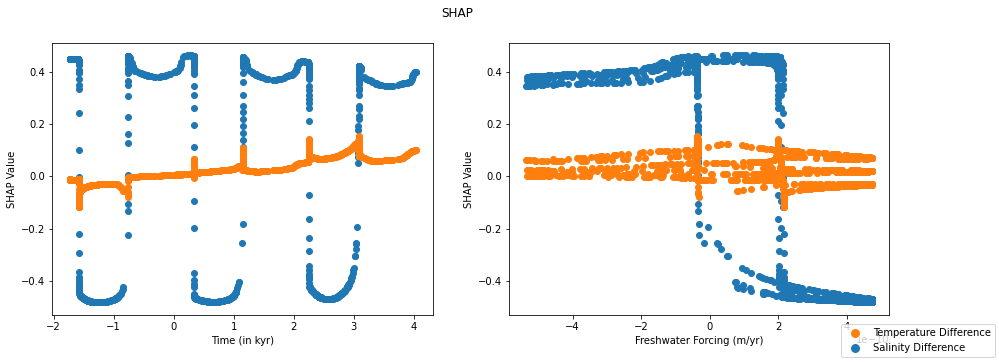

In [48]:
plot_shap_time_fwf("s", "mlp")

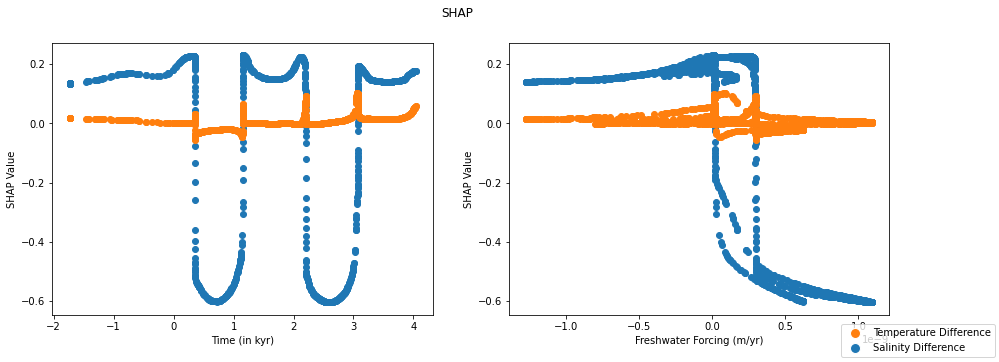

In [49]:
plot_shap_time_fwf("ns", "mlp")

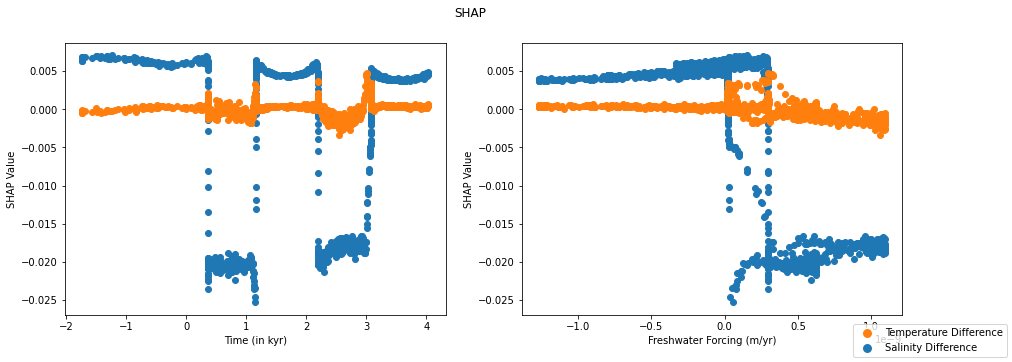

In [29]:
plot_shap_time_fwf("ns", "lstm")

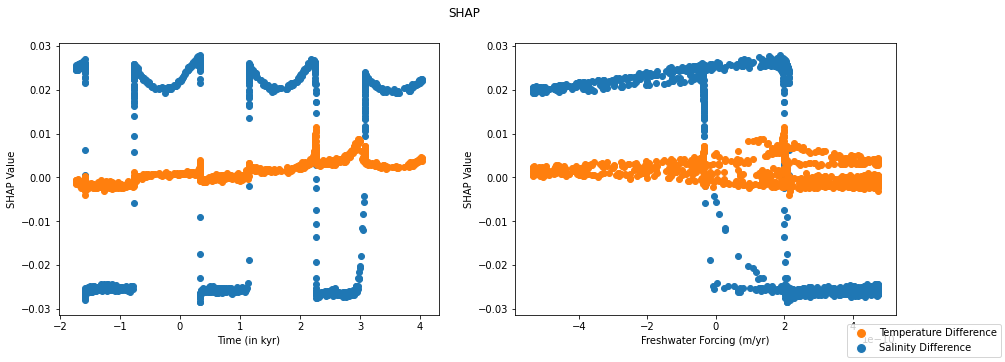

In [28]:
plot_shap_time_fwf("s", "lstm")

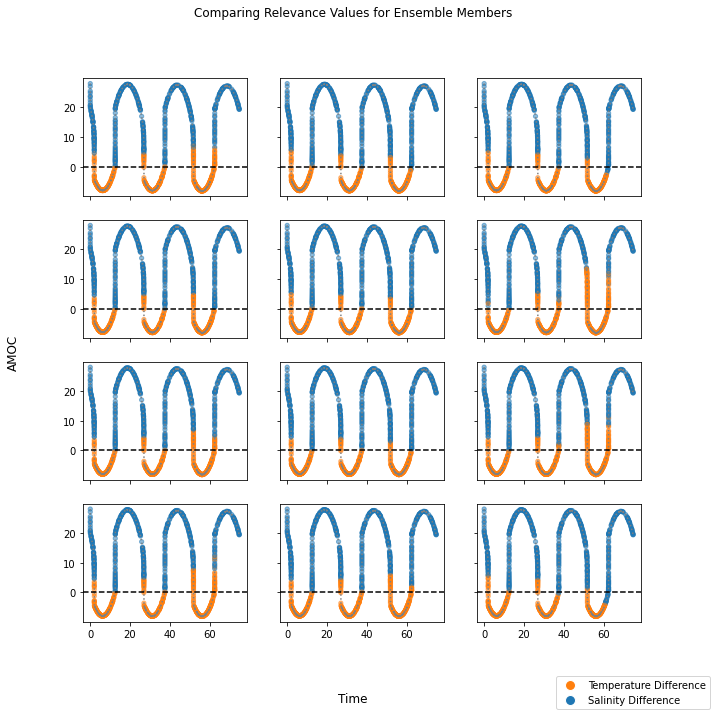

In [30]:
plot_shap_dominance_members("s", "lstm", "t")

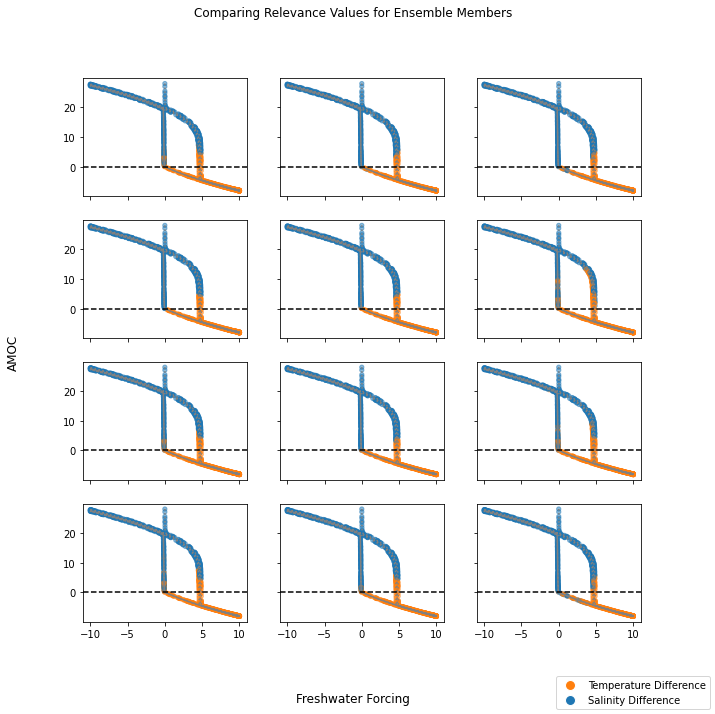

In [31]:
plot_shap_dominance_members("s", "lstm", "fwf")

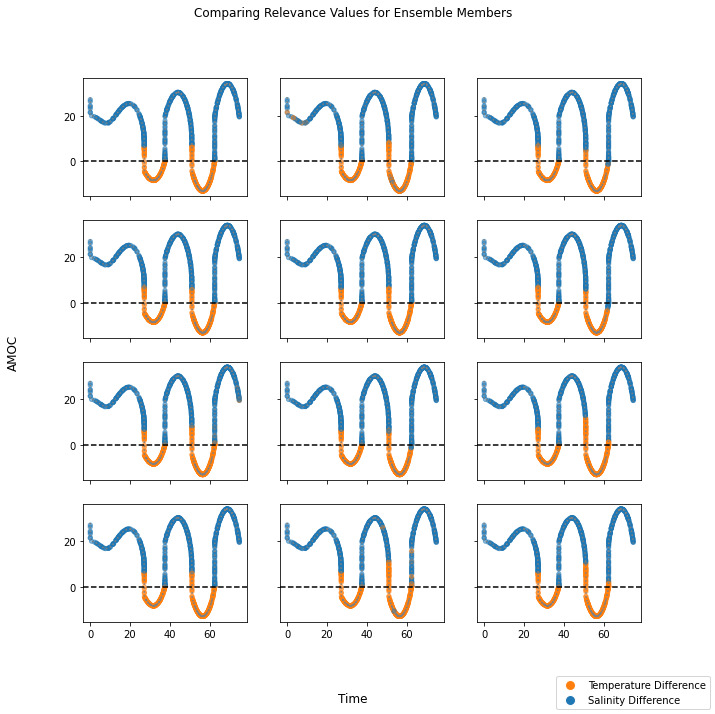

In [42]:
plot_shap_dominance_members("ns", "lstm", "t")

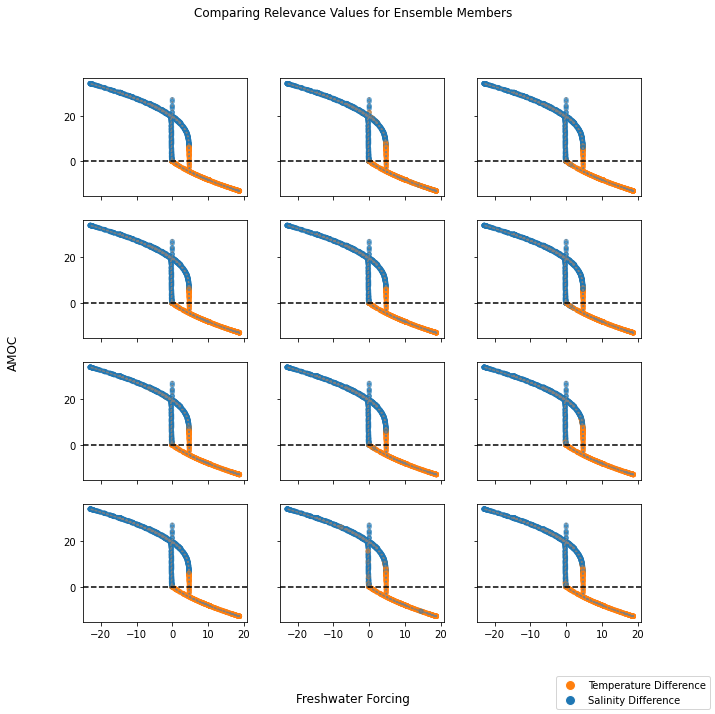

In [43]:
plot_shap_dominance_members("ns", "lstm", "fwf")

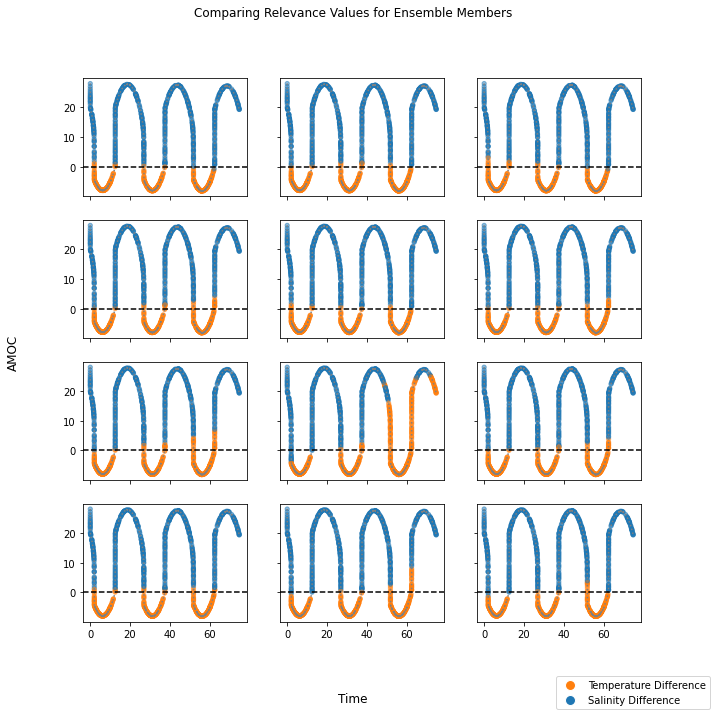

In [50]:
plot_shap_dominance_members("s", "mlp", "t")

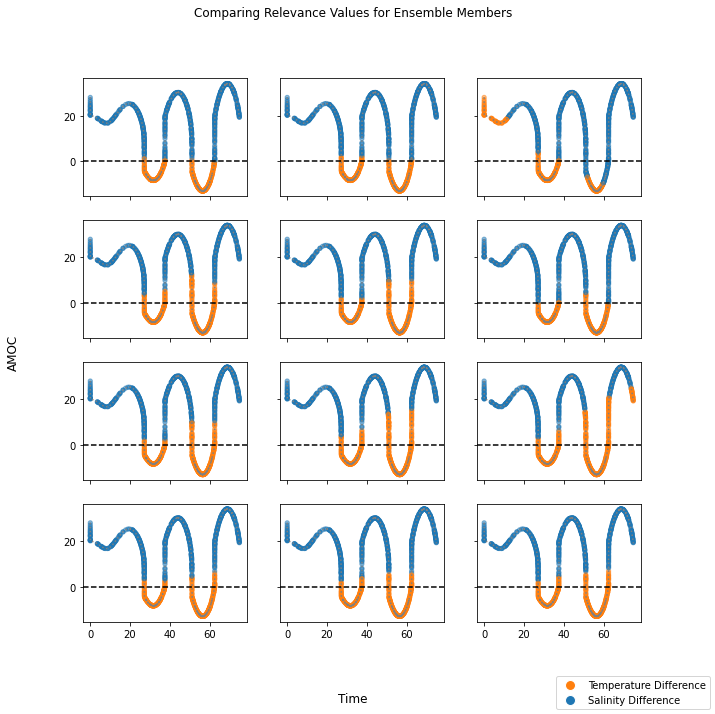

In [51]:
plot_shap_dominance_members("ns", "mlp", "t")

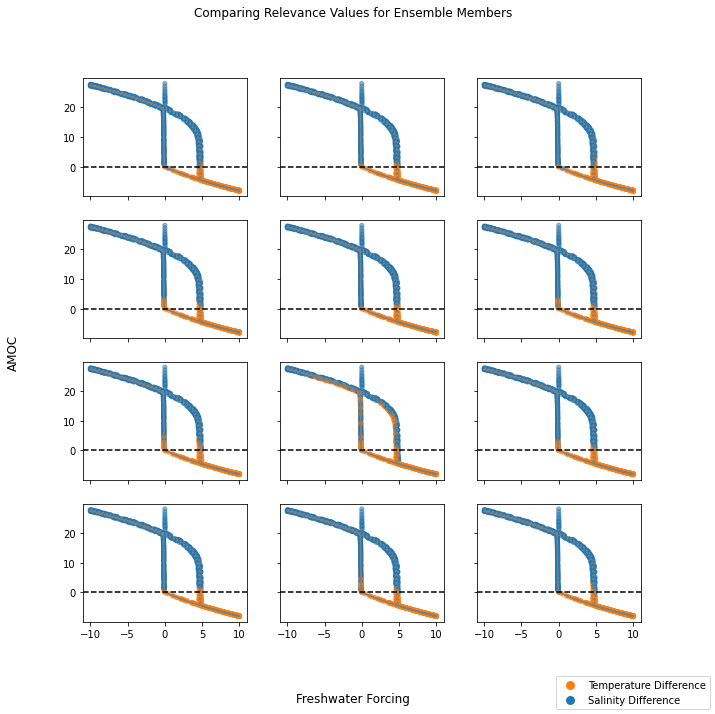

In [52]:
plot_shap_dominance_members("s", "mlp", "fwf")

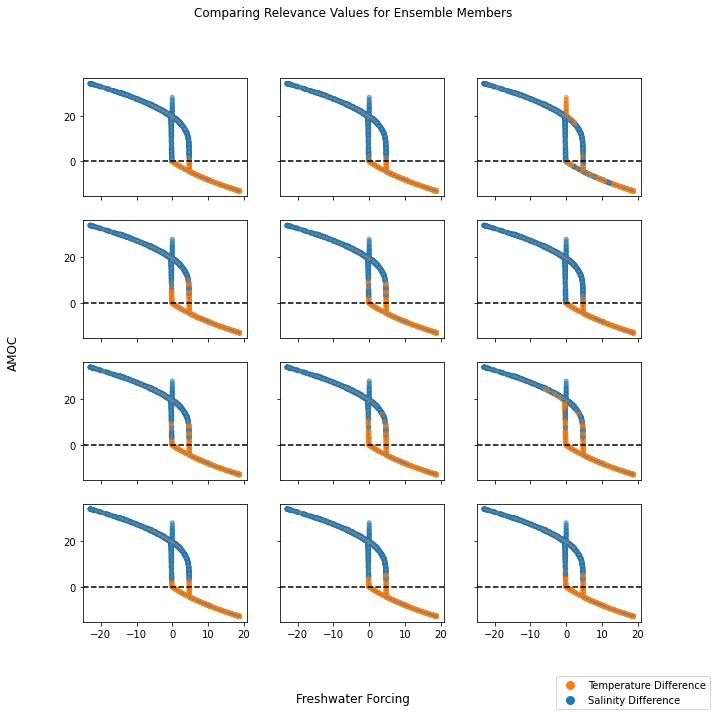

In [53]:
plot_shap_dominance_members("ns", "mlp", "fwf")

0
32/32 [==============================] - 1s 2ms/step - loss: 0.2520 - accuracy: 0.9670
Sample loss: 0.25203683972358704
Sample accuracy: 0.9670000076293945
32/32 [==============================] - 0s 2ms/step
1
32/32 [==============================] - 1s 2ms/step - loss: 0.1348 - accuracy: 0.9700
Sample loss: 0.1347522884607315
Sample accuracy: 0.9700000286102295
32/32 [==============================] - 0s 1ms/step
2
32/32 [==============================] - 1s 2ms/step - loss: 0.1396 - accuracy: 0.9680
Sample loss: 0.13956163823604584
Sample accuracy: 0.9679999947547913
32/32 [==============================] - 0s 2ms/step
3
32/32 [==============================] - 1s 2ms/step - loss: 0.2923 - accuracy: 0.9650
Sample loss: 0.2922612130641937
Sample accuracy: 0.9649999737739563
32/32 [==============================] - 0s 2ms/step
4
32/32 [==============================] - 1s 2ms/step - loss: 0.1558 - accuracy: 0.9640
Sample loss: 0.15582707524299622
Sample accuracy: 0.9639999866485596


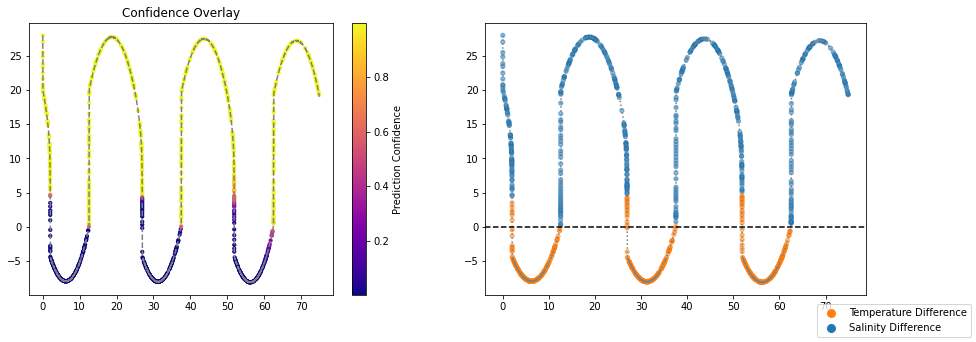

In [44]:
plot_shap_dominance_ensemble("s", "lstm", "t")

0
32/32 [==============================] - 1s 989us/step - loss: 0.0271 - accuracy: 0.9860
Sample loss: 0.027051184326410294
Sample accuracy: 0.9860000014305115
32/32 [==============================] - 0s 895us/step
1
32/32 [==============================] - 0s 1ms/step - loss: 0.0364 - accuracy: 0.9820
Sample loss: 0.03635524585843086
Sample accuracy: 0.9819999933242798
32/32 [==============================] - 0s 886us/step
2
32/32 [==============================] - 0s 1ms/step - loss: 0.0602 - accuracy: 0.9760
Sample loss: 0.060200560837984085
Sample accuracy: 0.9760000109672546
32/32 [==============================] - 0s 960us/step
3
32/32 [==============================] - 0s 1ms/step - loss: 0.0298 - accuracy: 0.9860
Sample loss: 0.029795005917549133
Sample accuracy: 0.9860000014305115
32/32 [==============================] - 0s 947us/step
4
32/32 [==============================] - 0s 1ms/step - loss: 0.1062 - accuracy: 0.9710
Sample loss: 0.10618860274553299
Sample accuracy: 0.97

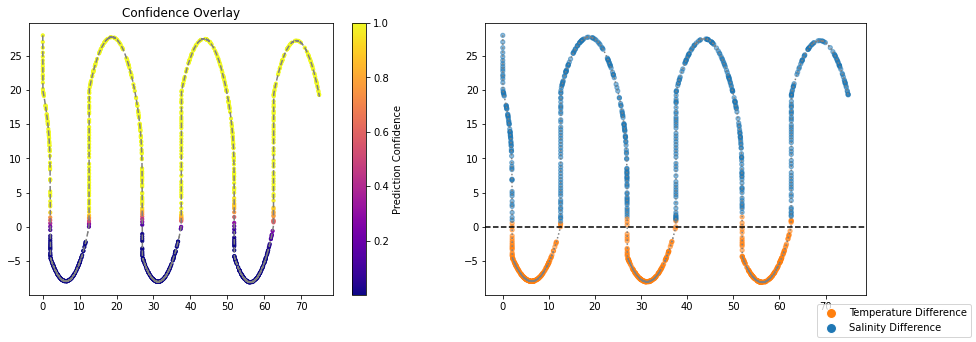

In [54]:
plot_shap_dominance_ensemble("s", "mlp", "t")

0
32/32 [==============================] - 0s 2ms/step - loss: 0.2520 - accuracy: 0.9670
Sample loss: 0.25203683972358704
Sample accuracy: 0.9670000076293945
32/32 [==============================] - 0s 1ms/step
1
32/32 [==============================] - 0s 2ms/step - loss: 0.1348 - accuracy: 0.9700
Sample loss: 0.1347522884607315
Sample accuracy: 0.9700000286102295
32/32 [==============================] - 0s 1ms/step
2
32/32 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.9680
Sample loss: 0.13956163823604584
Sample accuracy: 0.9679999947547913
32/32 [==============================] - 0s 1ms/step
3
32/32 [==============================] - 0s 2ms/step - loss: 0.2923 - accuracy: 0.9650
Sample loss: 0.2922612130641937
Sample accuracy: 0.9649999737739563
32/32 [==============================] - 0s 1ms/step
4
32/32 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9640
Sample loss: 0.15582707524299622
Sample accuracy: 0.9639999866485596


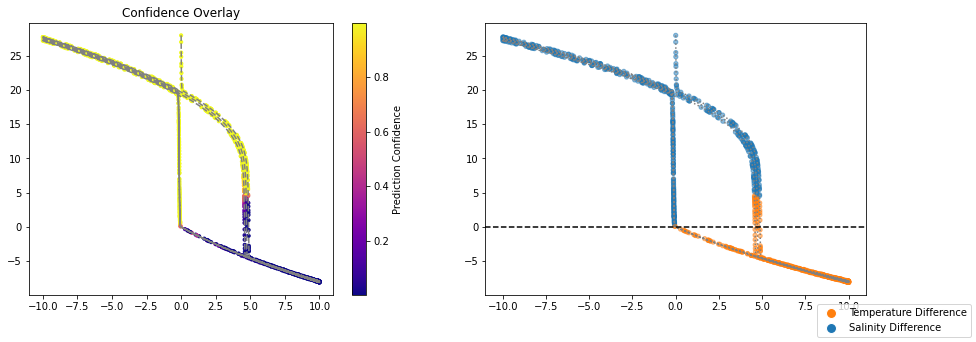

In [45]:
plot_shap_dominance_ensemble("s", "lstm", "fwf")

0
32/32 [==============================] - 1s 3ms/step - loss: 0.3227 - accuracy: 0.9020
Sample loss: 0.3227478265762329
Sample accuracy: 0.9020000100135803
32/32 [==============================] - 0s 3ms/step
1
32/32 [==============================] - 1s 2ms/step - loss: 0.2701 - accuracy: 0.9440
Sample loss: 0.2701434791088104
Sample accuracy: 0.9440000057220459
32/32 [==============================] - 0s 2ms/step
2
32/32 [==============================] - 1s 2ms/step - loss: 0.3063 - accuracy: 0.9430
Sample loss: 0.3062950670719147
Sample accuracy: 0.9430000185966492
32/32 [==============================] - 0s 2ms/step
3
32/32 [==============================] - 1s 2ms/step - loss: 0.1999 - accuracy: 0.9520
Sample loss: 0.19994884729385376
Sample accuracy: 0.9520000219345093
32/32 [==============================] - 0s 2ms/step
4
32/32 [==============================] - 1s 2ms/step - loss: 0.1594 - accuracy: 0.9640
Sample loss: 0.15937046706676483
Sample accuracy: 0.9639999866485596
3

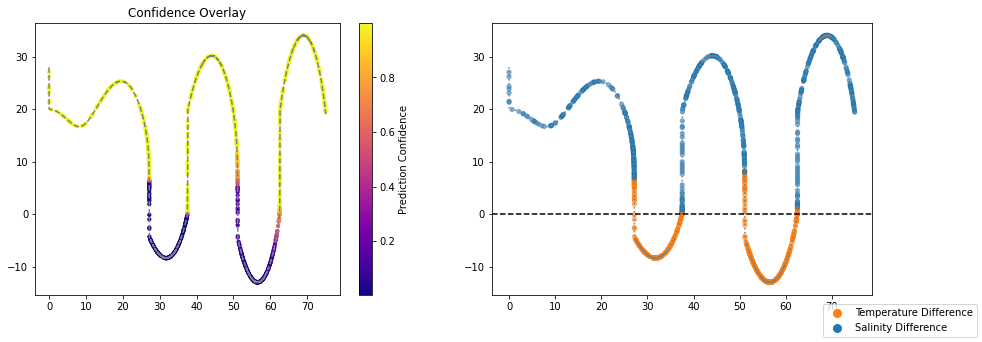

In [46]:
plot_shap_dominance_ensemble("ns", "lstm", "t")

0
32/32 [==============================] - 1s 2ms/step - loss: 0.3227 - accuracy: 0.9020
Sample loss: 0.3227478265762329
Sample accuracy: 0.9020000100135803
32/32 [==============================] - 0s 2ms/step
1
32/32 [==============================] - 1s 2ms/step - loss: 0.2701 - accuracy: 0.9440
Sample loss: 0.2701434791088104
Sample accuracy: 0.9440000057220459
32/32 [==============================] - 0s 2ms/step
2
32/32 [==============================] - 1s 2ms/step - loss: 0.3063 - accuracy: 0.9430
Sample loss: 0.3062950670719147
Sample accuracy: 0.9430000185966492
32/32 [==============================] - 0s 2ms/step
3
32/32 [==============================] - 1s 2ms/step - loss: 0.1999 - accuracy: 0.9520
Sample loss: 0.19994884729385376
Sample accuracy: 0.9520000219345093
32/32 [==============================] - 0s 2ms/step
4
32/32 [==============================] - 1s 2ms/step - loss: 0.1594 - accuracy: 0.9640
Sample loss: 0.15937046706676483
Sample accuracy: 0.9639999866485596
3

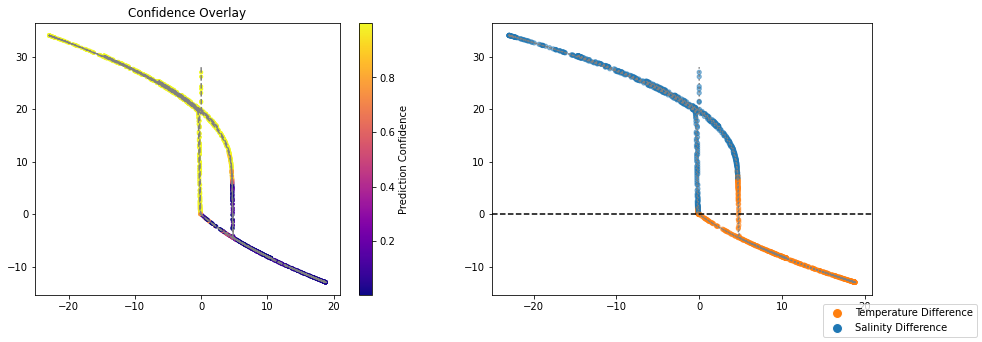

In [47]:
plot_shap_dominance_ensemble("ns", "lstm", "fwf")